In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

In [5]:
ensm_hist = xr.open_mfdataset('DATA/ensm_uas_hist.nc')
ensm_s245 = xr.open_mfdataset('DATA/ensm_uas_s245.nc')
ensm_s585 = xr.open_mfdataset('DATA/ensm_uas_s585.nc')
tern = xr.open_dataset('DATA/bird_heatmap.nc')

In [7]:
def sel_region(dataset, months, extent=None):
    """
    Takes variable data of interest and averages over months
    (and optional region) of interest.
    
    Inputs:
    - months: List of integers corresponding to months
    - extent (optional): List of bounding coordinates for clipping
    region in the form [min_lon, max_lon, min_lat, max_lat].
    Returns: Processed dataset
    """
    if extent:
        print(f'Clipping region {extent[0]} to {extent[1]}E and {extent[2]} to {extent[3]}N')
        ds = dataset.sel(month=months,
                     lon=slice(extent[0],extent[1]),
                     lat=slice(extent[2],extent[3])).mean(dim='month')
    else:
        ds = dataset.sel(month=months).mean(dim='month')
    return ds


sob = [-180, 180, -85, -0] # Southern ocean region
aob = [-180, 180, 0, 85] # North Atlantic region
som = [11,12,1,2,3] # Austral summer foraging season
aom = [5,6,7,8]     # Arctic summer breeding season

In [15]:
ao_ensm_hist = sel_region(ensm_hist, aom, aob)
ao_ensm_s245 = sel_region(ensm_s245, aom, aob)
ao_ensm_s585 = sel_region(ensm_s585, aom, aob)
so_ensm_hist = sel_region(ensm_hist, som, sob)
so_ensm_s245 = sel_region(ensm_s245, som, sob)
so_ensm_s585 = sel_region(ensm_s585, som, sob)

Clipping region -180 to 180E and 0 to 85N
Clipping region -180 to 180E and 0 to 85N
Clipping region -180 to 180E and 0 to 85N
Clipping region -180 to 180E and -85 to 0N
Clipping region -180 to 180E and -85 to 0N
Clipping region -180 to 180E and -85 to 0N


In [46]:
def select_data(which_data, polar_stereo=False):
    """Plots data for hemisphere of interest"""
    if polar_stereo == True:
        ps  = True
    else: ps = False
    
    if which_data == 'S':
        return plot_zonal_winds_climate(southern_kwargs, ps)
    elif which_data == 'N':
        return plot_zonal_winds_climate(northern_kwargs, ps)
    else: return 0

def plot_zonal_winds_climate(kwargs, polar_stereo=False):
    """Plotting script"""
    if polar_stereo == True:
        fig = plt.figure(figsize=(7,10), constrained_layout=False)
    else:
        fig = plt.figure(figsize=(12,5), constrained_layout=False)

    gs = fig.add_gridspec(3, 4)
    csps = ccrs.NearsidePerspective(central_longitude=0.0,central_latitude=-90.0,satellite_height=35785831)
    cnps = ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=90.0, satellite_height=35785831)

    if polar_stereo == True:
        if kwargs == southern_kwargs:
            f_ax1 = fig.add_subplot(gs[0, 1:-1], projection=csps)
            f_ax2a = fig.add_subplot(gs[1, :2], projection=csps)
            f_ax3a = fig.add_subplot(gs[1, -2:], projection=csps)
            f_ax2b = fig.add_subplot(gs[-1, :2], projection=csps)
            f_ax3b = fig.add_subplot(gs[-1, -2:], projection=csps)

            fig.text(0.08, 0.77, 'b', fontsize=18)
            fig.text(0.08, 0.5, 'd', fontsize=18)
            fig.text(0.08, 0.23, 'f', fontsize=18)

        elif kwargs == northern_kwargs:
            f_ax1 = fig.add_subplot(gs[0, 1:-1], projection=cnps)
            f_ax2a = fig.add_subplot(gs[1, :2], projection=cnps)
            f_ax3a = fig.add_subplot(gs[1, -2:], projection=cnps)
            f_ax2b = fig.add_subplot(gs[-1, :2], projection=cnps)
            f_ax3b = fig.add_subplot(gs[-1, -2:], projection=cnps)

            fig.text(0.08, 0.77, 'a', fontsize=18)
            fig.text(0.08, 0.5, 'c', fontsize=18)
            fig.text(0.08, 0.23, 'e', fontsize=18)

    else:
        f_ax1 = fig.add_subplot(gs[0, 1:-1], projection=kwargs['projection'])
        f_ax2a = fig.add_subplot(gs[1, :2], projection=kwargs['projection'])
        f_ax3a = fig.add_subplot(gs[1, -2:], projection=kwargs['projection'])
        f_ax2b = fig.add_subplot(gs[-1, :2], projection=kwargs['projection'])
        f_ax3b = fig.add_subplot(gs[-1, -2:], projection=kwargs['projection'])

    gs_axs = [f_ax1, f_ax2a, f_ax2b, f_ax3a, f_ax3b]

    for ax in gs_axs:
        ax.coastlines(resolution='110m', color=(0.25,0.25,0.25), linewidth=0.8)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.8, color='silver', alpha=0.8, linestyle='-')

    hatch_kwarg = dict(colors='none', levels=[0,0.5], hatches=[None, 'xxxx'],
                       extend='max', transform=ccrs.PlateCarree(), zorder=5)

    pc = kwargs['hist'].uas.plot.contourf(ax=f_ax1, **kwargs['cont_kwarg'])
    kwargs['s245'].uas.plot.contourf(ax=f_ax2a, **kwargs['cont_kwarg'])
    pm = (kwargs['s245']-kwargs['hist']).uas.plot.pcolormesh(ax=f_ax2b, **kwargs['mesh_kwarg'])
    kwargs['s585'].uas.plot.contourf(ax=f_ax3a, **kwargs['cont_kwarg'])
    (kwargs['s585']-kwargs['hist']).uas.plot.pcolormesh(ax=f_ax3b, **kwargs['mesh_kwarg'])

    f_ax2b.contourf(tern.longitude[0], tern.latitude[:,0], tern.density, **hatch_kwarg)
    f_ax3b.contourf(tern.longitude[0], tern.latitude[:,0], tern.density, **hatch_kwarg)

    f_ax1.set_title('Historical (1960-2014)')
    f_ax2a.set_title('SSP245 (2080-2099)')
    f_ax2b.set_title('Change (SSP245-Hist)')
    f_ax3a.set_title('SSP585 (2080-2099)')
    f_ax3b.set_title('Change (SSP585-Hist)')

    ax_cb = plt.axes([0.92, 0.5, 0.015, 0.25])
    ax_cb2 = plt.axes([0.92, 0.13, 0.015, 0.2])
    cbc = plt.colorbar(pc,cax=ax_cb, orientation='vertical')
    cbm = plt.colorbar(pm,cax=ax_cb2, orientation='vertical', extend='both')
    cbc.ax.set_ylabel(r'Avg. Zonal Wind (ms$^{-1})$')
    cbm.ax.set_ylabel(r'Zonal Wind Change (ms$^{-1})$')
    cbc.patch.set_facecolor("none")
    cbm.patch.set_facecolor("none")

    if kwargs == southern_kwargs:
        plt.savefig('FIGURES/ens_wind_zonal_sh.pdf', bbox_inches='tight')#, dpi=1000)
    elif kwargs == northern_kwargs:
        plt.savefig('FIGURES/ens_wind_zonal_nh.pdf', bbox_inches='tight')#, dpi=1000)

    plt.show()


southern_kwargs = {'bounds': [-180, 180, -85, -0], # Southern ocean region
                   'months': [11,12,1,2,3], # Austral summer foraging season
                   'projection': ccrs.Mercator(central_longitude=0.0, min_latitude=-72.5, max_latitude=-5.0),
                   'cont_kwarg': dict(x='lon', y='lat', add_colorbar=False, transform=ccrs.PlateCarree(),
                                      cmap='RdBu_r', vmin=-8, vmax=8, levels=9, extend='both'),
                   'mesh_kwarg': dict(x='lon', y='lat', add_colorbar=False, transform=ccrs.PlateCarree(),
                                      cmap='PiYG_r', center=0, vmax=2),
                   'hist':so_ensm_hist,
                   's245':so_ensm_s245,
                   's585':so_ensm_s585
                  }

northern_kwargs = {'bounds': [-180, 180, 0, 85], # North Atlantic region
                   'months': [5,6,7,8],     # Arctic summer breeding season
                   'projection': ccrs.Mercator(central_longitude=0.0, min_latitude=40, max_latitude=80),
                   'cont_kwarg': dict(x='lon', y='lat', add_colorbar=False, transform=ccrs.PlateCarree(),
                                      cmap='RdBu_r', vmin=-4, vmax=4, levels=9, extend='both'),
                   'mesh_kwarg': dict(x='lon', y='lat', add_colorbar=False, transform=ccrs.PlateCarree(),
                                      cmap='PiYG_r', center=0, vmax=2),
                   'hist':ao_ensm_hist,
                   's245':ao_ensm_s245,
                   's585':ao_ensm_s585
                  }


#### Southern Hemisphere Zonal Wind Changes

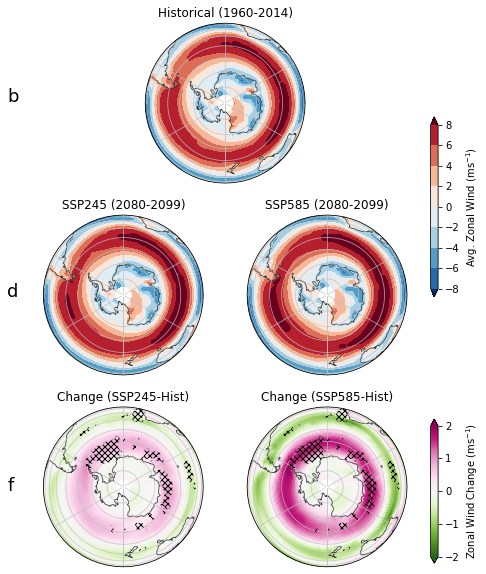

In [47]:
select_data('S', polar_stereo=True)

#### Northern Hemisphere Zonal Wind Changes

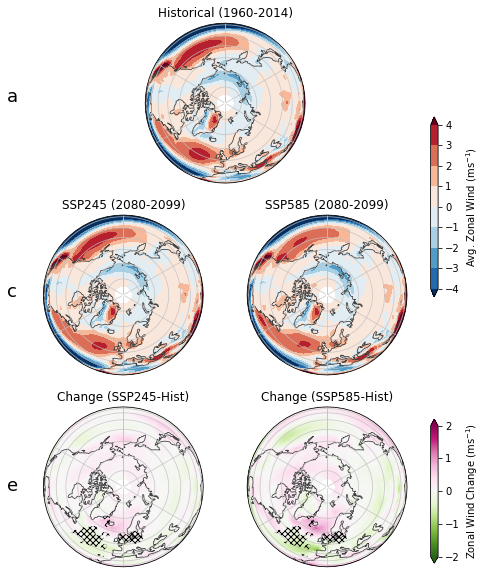

In [48]:
select_data('N', polar_stereo=True)